# Import

In [44]:
### Import the important libraries
# you need to import gdal, tensorflow_gpu, numpy, matplotlib, Pillow, keras, openCV, segmentation_models, sklearn
from osgeo import gdal
import tensorflow as tf
import datetime
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import random
from keras import optimizers
from keras.utils.np_utils import to_categorical
from keras.utils import multi_gpu_model, plot_model
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, CSVLogger
from keras import backend as K
import cv2
import sklearn
import segmentation_models

# Read Data

In [45]:
def scene_folder_list(catagory, pathrow_list, data_source_folder='/workspace/_libs/DL_Training_Library'):
    source_folder = os.path.join(data_source_folder,catagory)
    res_folder_list = []
    total_num = len(pathrow_list)
    success_num = 0
    for pathrow in pathrow_list:
        for folder in os.listdir(source_folder):
            if folder.endswith(pathrow):
                res_folder_list.append(os.path.join(source_folder,folder))
                success_num+=1
    print(str(success_num),'scenes exist for',str(total_num),'required scenes')
    return res_folder_list

def read_scenes(scene_folder_list):
    for i in range(len(scene_folder_list)):
        if(i==0):
            folder = scene_folder_list[i]
            res_bands, res_label = read_scene_band_label(folder)
        else:
            folder = scene_folder_list[i]
            scene_bands, scene_label = read_scene_band_label(folder)
            res_bands = np.append(res_bands, scene_bands, axis=0)
            res_label = np.append(res_label, scene_label, axis=0)
    return res_bands, res_label


def read_scene_band_label(scene_folder):
    """
This function is to read bands and label from the
    :param scene_folder: the folder path of a scene
    :return: numpy arrays of bands and the label
    """
    # empty list to save the band and label
    band_array = []
    label_array = []
    # get the band and label folder
    for folder in os.listdir(scene_folder):
        if(folder.endswith('bands')):
            scene_band_folder = os.path.join(scene_folder,folder)
        if(folder.endswith('label')):
            scene_label_folder = os.path.join(scene_folder,folder)
    # save each band chips to the list
    band_list = os.listdir(scene_band_folder)
    label_list = os.listdir(scene_label_folder)
    band_list.sort()
    label_list.sort()
    for i in band_list:
        file = gdal.Open(os.path.join(scene_band_folder,i))
        res_array = np.zeros((256, 256, 6))
        for num in range(6):
            array = np.array(file.GetRasterBand(num+1).ReadAsArray())
            res_array[:,:,num] = array
        band_array.append(res_array)
        del file
    # save each label chip to the list
    for i in label_list:
        file = gdal.Open(os.path.join(scene_label_folder,i))
        array = np.array(file.GetRasterBand(1).ReadAsArray())
        label_array.append(array)
        del file
    return np.array(band_array), np.array(label_array)

# data augmentation

In [46]:
# rotation for 90, 180, 270, and horizotal and vertical flip
def clarkAug(bands, label):
    ## rotation 1 for 90, 2 for 180, 3 for 270
    image_rot90 = np.rot90(bands, 1, axes=(1, 2))
    label_rot90 = np.rot90(label, 1, axes=(1, 2))
    image_rot180 = np.rot90(bands, 2, axes=(1, 2))
    label_rot180 = np.rot90(label, 2, axes=(1, 2))
    image_rot270 = np.rot90(bands, 3, axes=(1, 2))
    label_rot270 = np.rot90(label, 3, axes=(1, 2))
    # axis=1 vertical flip, axis=2 horizontasl flip
    image_vflip = np.flip(bands, axis=1)
    label_vflip = np.flip(label, axis=1)
    image_hflip = np.flip(bands, axis=2)
    label_hflip = np.flip(label, axis=2)
    res_bands = np.vstack([bands, image_rot90, image_rot180, image_rot270, image_vflip, image_hflip])
    res_label = np.vstack([label, label_rot90, label_rot180, label_rot270, label_vflip, label_hflip])
    np.random.seed(42)
    np.random.shuffle(res_bands)
    np.random.seed(42)
    np.random.shuffle(res_label)
    return res_bands, res_label

# model

## Unet

In [47]:
### Import the important libraries
from osgeo import gdal
import tensorflow as tf
import datetime
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import random
from keras import optimizers
from keras.utils.np_utils import to_categorical
from keras.utils import multi_gpu_model, plot_model
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";

In [48]:
def binary_unet(input_height, input_width, bandNum):
    inputs = Input((input_height,input_width, bandNum))
    # Block one
    # (256, 256, numBands) -> (256, 256, 64)
    conv1 = BatchNormalization()(Conv2D(64, 3, padding='same', name='Conv1_1', kernel_initializer='he_normal')(inputs))
    conv1 = Activation('relu')(conv1)
    conv1 = BatchNormalization()(Conv2D(64, 3, padding='same', name='Conv1_2', kernel_initializer='he_normal')(conv1))
    conv1 = Activation('relu')(conv1)
    # (256, 256, 64) -> (128, 128, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # Block Two
    # (128, 128, 64) -> (128, 128, 128)
    conv2 = BatchNormalization()(Conv2D(128, 3, padding='same', name='Conv2_1', kernel_initializer='he_normal')(pool1))
    conv2 = Activation('relu')(conv2)
    conv2 = BatchNormalization()(Conv2D(128, 3, padding='same', name='Conv2_2', kernel_initializer='he_normal')(conv2))
    conv2 = Activation('relu')(conv2)
    # (128, 128, 128) -> (64, 64, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Block three
    # (64, 64, 128) -> (64, 64, 256)
    conv3 = BatchNormalization()(Conv2D(256, 3, padding='same', name='Conv3_1', kernel_initializer='he_normal')(pool2))
    conv3 = Activation('relu')(conv3)
    conv3 = BatchNormalization()(Conv2D(256, 3, padding='same', name='Conv3_2', kernel_initializer='he_normal')(conv3))
    conv3 = Activation('relu')(conv3)
    # (64, 64, 256) -> ( 32, 32, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Block four
    # (32, 32, 256) -> (32, 32, 512)
    conv4 = BatchNormalization()(Conv2D(512, 3, padding='same', name='Conv4_1', kernel_initializer='he_normal')(pool3))
    conv4 = Activation('relu')(conv4)
    conv4 = BatchNormalization()(Conv2D(512, 3, padding='same', name='Conv4_2', kernel_initializer='he_normal')(conv4))
    conv4 = Activation('relu')(conv4)
    # (32, 32, 512) -> (16, 16, 512)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Block five
    # (16, 16, 512) -> (16, 16, 1024)
    conv5 = BatchNormalization()(Conv2D(1024, 3, padding='same', name='Conv5_1', kernel_initializer='he_normal')(pool4))
    conv5 = Activation('relu')(conv5)
    conv5 = BatchNormalization()(Conv2D(1024, 3, padding='same', name='Conv5_2', kernel_initializer='he_normal')(conv5))
    conv5 = Activation('relu')(conv5)
    
    ## Decoder 
    # Block six
    # (16, 16, 1024) -> (32, 32, 1024) -> (32, 32, 512)
    up6 = Conv2DTranspose(512, (4, 4), strides=(2, 2), name = 'Conv6_1', padding='same')(conv5)
    # (32, 32, 512) -> (32, 32, 1024)
    merge6 = concatenate([conv4,up6],axis = 3)   
    # (32, 32, 1024) -> (32, 32, 512)
    conv6 = (Conv2D(512, 3,  padding = 'same', name = 'Conv6_2', kernel_initializer = 'he_normal')(merge6))
    conv6 = Activation('relu')(conv6) 
    conv6 = (Conv2D(512, 3, padding = 'same', name = 'Conv6_3', kernel_initializer = 'he_normal')(conv6))
    conv6 = Activation('relu')(conv6) 
    
    # Block seven 
    # (32, 32, 512) -> (64, 64, 512) -> (64, 64, 256)
    up7 = Conv2DTranspose(256, (4, 4), strides=(2, 2), name = 'Conv7_1', padding='same')(conv6)
    # (64, 64, 256) -> (64, 64, 512)
    merge7 = concatenate([conv3,up7],axis = 3)
    # (64, 64, 512) -> (64, 64, 256)
    conv7 = (Conv2D(256, 3,  padding = 'same', name = 'Conv7_2', kernel_initializer = 'he_normal')(merge7))
    conv7 = Activation('relu')(conv7)          
    conv7 = (Conv2D(256, 3, padding = 'same', name = 'Conv7_3', kernel_initializer = 'he_normal')(conv7))
    conv7 = Activation('relu')(conv7)  
                       
    # Block eight 
    # (64, 64, 256) -> (128, 128, 256) -> (128, 128, 128)
    up8 = Conv2DTranspose(128, (4, 4), strides=(2, 2), name = 'Conv8_1', padding='same')(conv7)
    # (128, 128, 128) -> (128, 128, 256)
    merge8 = concatenate([conv2,up8],axis = 3)   
    # (128, 128, 256) -> (128, 128, 128)
    conv8 = (Conv2D(128, 3, padding = 'same', name = 'Conv8_2', kernel_initializer = 'he_normal')(merge8))
    conv8 = Activation('relu')(conv8)                     
    conv8 = (Conv2D(128, 3,  padding = 'same', name = 'Conv8_3', kernel_initializer = 'he_normal')(conv8))
    conv8 = Activation('relu')(conv8)  
    
    # Block nine 
    # (128, 128, 128) -> (256, 256, 128) -> (256, 256, 64)
    up9 = Conv2DTranspose(64, (4, 4), strides=(2, 2), name = 'Conv9_1', padding='same')(conv8)
    # (256, 256, 64) -> (256, 256, 128)
    merge9 = concatenate([conv1,up9],axis = 3)
    # (256, 256, 128) -> (256, 256, 64)                  
    conv9 = (Conv2D(64, 3, padding = 'same',name = 'Conv9_2', kernel_initializer = 'he_normal')(merge9))
    conv9 = Activation('relu')(conv9)                   
    conv9 = (Conv2D(64, 3, padding = 'same', name = 'Conv9_3', kernel_initializer = 'he_normal')(conv9))
    conv9 = Activation('relu')(conv9)  
    
    # (256, 256, 64) -> (256, 256, 64)
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    model = Model(inputs, outputs = conv10)
    
    return model

## FCN

In [49]:
# initiate transposed convolution layer 4*4 kernel with bilinear upsampling weights
def my_init(shape, dtype = tf.float32):
    filter_size = 4
    num_channels = 2
    bilinear_kernel = np.zeros([filter_size, filter_size], dtype=np.float32)
    scale_factor = (filter_size + 1) // 2
    if filter_size % 2 == 1:
        center = scale_factor - 1
    else:
        center = scale_factor - 0.5
    for x in range(filter_size):
        for y in range(filter_size):
            bilinear_kernel[x, y] = (1 - abs(x - center) / scale_factor) * \
                                    (1 - abs(y - center) / scale_factor)
    bilinear_weights = np.zeros((filter_size, filter_size, num_channels, num_channels))
    for i in range(num_channels):
        bilinear_weights[:, :, i, i] = bilinear_kernel
    bilinear_init = tf.keras.initializers.Constant(bilinear_weights)
    return bilinear_weights

In [50]:
def binary_FCN2( input_height, input_width, bandNum):
    ## input_height and width must be devisible by 32 because maxpooling with filter size = (2,2) is operated 5 times,
    ## which makes the input_height and width 2^5 = 32 times smaller
    assert input_height%32 == 0
    assert input_width%32 == 0
    IMAGE_ORDERING =  "channels_last" 

    img_input = Input(shape=(input_height,input_width, bandNum)) ## Assume 224,224,3
    
    ## Block 1
#     x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', data_format=IMAGE_ORDERING )(img_input)
#     x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1', data_format=IMAGE_ORDERING )(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2', data_format=IMAGE_ORDERING )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool', data_format=IMAGE_ORDERING )(x)
    pool1 = x #120x120x64
    
    # Block 2
#     x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1', data_format=IMAGE_ORDERING )(x)
#     x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1', data_format=IMAGE_ORDERING )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2', data_format=IMAGE_ORDERING )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool', data_format=IMAGE_ORDERING )(x)
    pool2 = x #120x120x128

    # Block 3
#     x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1', data_format=IMAGE_ORDERING )(x)
#     x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2', data_format=IMAGE_ORDERING )(x)
#     x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1', data_format=IMAGE_ORDERING )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2', data_format=IMAGE_ORDERING )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3', data_format=IMAGE_ORDERING )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool', data_format=IMAGE_ORDERING )(x)
    pool3 = x #56x56x256

    # Block 4
#     x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1', data_format=IMAGE_ORDERING )(x)
#     x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2', data_format=IMAGE_ORDERING )(x)
#     x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1', data_format=IMAGE_ORDERING )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2', data_format=IMAGE_ORDERING )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3', data_format=IMAGE_ORDERING )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool', data_format=IMAGE_ORDERING )(x)## (None, 14, 14, 512) 
    pool4 = x
    #28x28x512
    # Block 5
#     x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1', data_format=IMAGE_ORDERING )(x)
#     x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2', data_format=IMAGE_ORDERING )(x)
#     x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), padding='same', name='block5_conv1', data_format=IMAGE_ORDERING )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='block5_conv2', data_format=IMAGE_ORDERING )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='block5_conv3', data_format=IMAGE_ORDERING )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    pool5 = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool', data_format=IMAGE_ORDERING )(x)## (None, 7, 7, 512)
    
    
#     vgg  = Model(  img_input , pool5  )
#     vgg.load_weights(VGG_Weights_path) ## loading VGG weights for the encoder parts of FCN8
    
    n = 4096
    o = ( Conv2D( n , ( 7 , 7 ) , activation='relu' , padding='same', name="conv6", data_format=IMAGE_ORDERING))(pool5)
    predict0 = ( Conv2D( n , ( 1 , 1 ) , activation='relu' , padding='same', name="predict0", data_format=IMAGE_ORDERING))(o) # my prefered 
    predict1 = ( Conv2D( 1 , ( 1 , 1 ) , activation='relu' , padding='same', name="predict1", data_format=IMAGE_ORDERING))(predict0)

#     predict1 = ( Conv2D( n , ( 1 , 1 ) , activation='relu' , padding='same', name="predict1", data_format=IMAGE_ORDERING))(o)

    
    ## 4 times upsamping for pool4 layer
#     Deconv1 = Conv2DTranspose( nClasses , kernel_size=(3,3) , padding = 'same', strides=(2,2) , use_bias=False, data_format=IMAGE_ORDERING )(predict1)
    Deconv1 = Conv2DTranspose( 1 , kernel_size=(4,4) , padding = 'same', strides=(2,2) , use_bias=False, kernel_initializer=my_init, data_format=IMAGE_ORDERING )(predict1)
#     Deconv1 = UpSampling2D(size=(2, 2), interpolation='bilinear', data_format=IMAGE_ORDERING)(predict1)

    ## (None, 224, 224, 10)
    ## 2 times upsampling for pool411
    
    predict2 = ( Conv2D( 1 , ( 1 , 1 ) , activation='relu' , padding='same', name="predict2", data_format=IMAGE_ORDERING))(pool4)
#     concat1= Concatenate(name='concat1')([predict2, Deconv1])
#     add_1 = Conv2D( 2 , ( 1 , 1 ) , activation='relu' , padding='same', name="add_1", data_format=IMAGE_ORDERING)(concat1)
    add_1 = Add(name="add_1")([predict2, Deconv1 ])
#     Deconv2 = (Conv2DTranspose( nClasses , kernel_size=(3,3) , padding = 'same', strides=(2,2) , use_bias=False, data_format=IMAGE_ORDERING ))(add_1)
    Deconv2 = (Conv2DTranspose( 1 , kernel_size=(4,4) , padding = 'same', strides=(2,2) , use_bias=False, kernel_initializer=my_init, data_format=IMAGE_ORDERING ))(add_1)
    #     Deconv2 = UpSampling2D(size=(2, 2), interpolation='bilinear', data_format=IMAGE_ORDERING)(add_1)
    
    predict3 = ( Conv2D( 1 , ( 1 , 1 ) , activation='relu' , padding='same', name="predict3", data_format=IMAGE_ORDERING))(pool3)
#     concat2= Concatenate(name='concat2')([predict3, Deconv2])
#     add_2 = Conv2D( 2 , ( 1 , 1 ) , activation='relu' , padding='same', name="add_2", data_format=IMAGE_ORDERING)(concat2)
    add_2 = Add(name="add_2")([predict3, Deconv2 ])
#     Deconv3 = Conv2DTranspose( nClasses , kernel_size=(3,3) , padding = 'same', strides=(2,2) , use_bias=False, data_format=IMAGE_ORDERING )(add_2)# deconv3
    Deconv3 = Conv2DTranspose( 1 , kernel_size=(4,4) , padding = 'same', strides=(2,2) , use_bias=False, kernel_initializer=my_init, data_format=IMAGE_ORDERING )(add_2)# deconv3
#     Deconv3 = UpSampling2D(size=(2, 2), interpolation='bilinear', data_format=IMAGE_ORDERING)(add_2)
    
    predict4 = ( Conv2D( 1 , ( 1 , 1 ) , activation='relu' , padding='same', name="predict4", data_format=IMAGE_ORDERING))(pool2)
#     concat3= Concatenate(name='concat3')([predict4, Deconv3])
#     add_3 = Conv2D( 2 , ( 1 , 1 ) , activation='relu' , padding='same', name="add_3", data_format=IMAGE_ORDERING)(concat3)
    add_3 = Add(name="add_3")([predict4, Deconv3 ])
#     Deconv4 = Conv2DTranspose( nClasses , kernel_size=(3,3) , padding = 'same', strides=(2,2) , use_bias=False, data_format=IMAGE_ORDERING )(add_3)# deconv3
    Deconv4 = Conv2DTranspose( 1 , kernel_size=(4,4) , padding = 'same', strides=(2,2) , use_bias=False, kernel_initializer=my_init, data_format=IMAGE_ORDERING )(add_3)# deconv3
#     Deconv4 = UpSampling2D(size=(2, 2), interpolation='bilinear', data_format=IMAGE_ORDERING)(add_3)
    
    predict5 = ( Conv2D( 1 , ( 1 , 1 ) , activation='relu' , padding='same', name="predict5", data_format=IMAGE_ORDERING))(pool1)
    
#     concat4= Concatenate(name='concat4')([predict5, Deconv4])
#     add_4 = Conv2D( 2 , ( 1 , 1 ) , activation='relu' , padding='same', name="add_4", data_format=IMAGE_ORDERING)(concat4)
    add_4 = Add(name="add_4")([predict5, Deconv4 ])
    Deconv5 = Conv2DTranspose( 1 , kernel_size=(4,4) , padding = 'same', strides=(2,2) , use_bias=False, kernel_initializer=my_init, data_format=IMAGE_ORDERING )(add_4)# deconv3
#     Deconv5 = UpSampling2D(size=(2, 2), interpolation='bilinear', data_format=IMAGE_ORDERING)(add_4)
    
#     o = Add(name="add")([predict2, predict3, Deconv1 ])# predict2, predict3,Deconv1
#     o = Conv2DTranspose( nClasses , kernel_size=(8,8) ,  strides=(8,8) , use_bias=False, data_format=IMAGE_ORDERING )(o)# deconv3
    o = (Activation('sigmoid'))(Deconv5)#sigmoid
    
    model = Model(img_input, o)
    

    return model

# Cut and Mosaic chips

In [51]:
### this function is to read the data and the relevant properties
def ReadData_geoinf(path):
    """
    This function is used to read geoinformation

    param path: img path

    """
    ds = gdal.Open(path, 0)
    if ds is None:
        sys.exit('Could not open {0}.'.format(path))

    geoTransform = ds.GetGeoTransform()
    proj = ds.GetProjection()

    XSize = ds.RasterXSize
    YSize = ds.RasterYSize
    MinX = geoTransform[0]
    MaxY = geoTransform[3]
    MaxX = MinX + geoTransform[1] * XSize
    MinY = MaxY + geoTransform[5] * YSize

    resolution = geoTransform[1]

    data = ds.ReadAsArray()
    res = {'data': data,
           'geoTransform': geoTransform,
           'projection': proj,
           'minX': MinX,
           'maxX': MaxX,
           'minY': MinY,
           'maxY': MaxY,
           'Xsize': XSize,
           'Ysize': YSize,
           'resolution': resolution}
    return res


In [52]:
## This function is to cut np.ndarray into chips.
def cut_array(data, row, col, row_buffer, col_buffer):
    ### calculate the right low corner index for row and col
    ### (row, col)
    ### the index for numpy array will be [a, b)
    data_row = data.shape[0]
    data_col = data.shape[1]
    if ((data_row - row) % (row - row_buffer) == 0):
        row_list = list(range(row, data_row + 1, row - row_buffer))
    else:
        row_list = list(range(row, data_row + 1, row - row_buffer))
        row_list.append(data_row)
    if ((data_col - col) % (col - col_buffer) == 0):
        col_list = list(range(col, data_col + 1, col - col_buffer))
    else:
        col_list = list(range(col, data_col + 1, col - col_buffer))
        col_list.append(data_col)
    res = []
    for j in col_list:
        for i in row_list:
            res.append(data[i - row:i, j - col:j])

    return np.array(res)

In [53]:
### index is from [0, row_num*col_num)
### return (minX, maxX, minY, maxY)
### This function is to return the coordinate range for the index
def chip_index_finder(index, row, col, data_row, data_col, row_buffer, col_buffer):
    if((data_row-row)%(row-row_buffer)>0):
        row_num = int((data_row-row)/(row-row_buffer))+2
    else:
        row_num = int((data_row-row)/(row-row_buffer))+1
    if((data_col-col)%(col-col_buffer)>0):
        col_num = int((data_col-col)/(col-col_buffer))+2
    else:
        col_num = int((data_col-col)/(col-col_buffer))+1
    row_index = index%row_num
    col_index = int(index/row_num)
    if(row_index == row_num-1):
        row_coor = data_row
    elif(row_index == 0):
        row_coor = row
    else:
        row_coor = row+(row_index)*(row-row_buffer)
    if(col_index == col_num-1):
        col_coor = data_col
    elif(col_index == 0):
        col_coor = col
    else:
        col_coor = col + col_index*(col-col_buffer)
    return (row_coor - row, row_coor, col_coor - col, col_coor)

In [54]:
def mosaic_chips(data_array, index_list, weight_array, data_row, data_col, row, col, row_buffer, col_buffer):
    res = np.zeros((data_row, data_col))
    for i in range(len(index_list)):
        chip_index = index_list[i]
        coors = chip_index_finder(chip_index, row, col, data_row, data_col, row_buffer, col_buffer)
        temp_array = weight_array[i,:,:]*data_array[i,:,:]
        res[coors[0]:coors[1],coors[2]:coors[3]] = res[coors[0]:coors[1],coors[2]:coors[3]]+temp_array
    return res

In [55]:
def weights_generator(weight_type, data_row, data_col, row, col, row_buffer, col_buffer):
    if ((data_row - row) % (row - row_buffer) > 0):
        row_num = int((data_row - row) / (row - row_buffer)) + 2
    else:
        row_num = int((data_row - row) / (row - row_buffer)) + 1
    if ((data_col - col) % (col - col_buffer) > 0):
        col_num = int((data_col - col) / (col - col_buffer)) + 2
    else:
        col_num = int((data_col - col) / (col - col_buffer)) + 1
    if (weight_type == 'no_buffer'):
        weight_array = [np.ones((row, col)) for _ in range(row_num * col_num)]
        right_margin = np.zeros((row, col))
        right_cut = (row if (data_row % row == 0) else data_row % row)
        right_margin[row - right_cut:, :] = 1
        down_margin = np.zeros((row, col))
        down_cut = (col if (data_col % col == 0) else data_col % col)
        down_margin[:, col - down_cut:] = 1
        corner_margin = right_margin * down_margin
        for i in range(row_num - 1, row_num * col_num, row_num):
            weight_array[i] = right_margin
        for i in range(row_num * col_num - row_num, row_num * col_num):
            weight_array[i] = down_margin
        weight_array[row_num * col_num - 1] = corner_margin
        weight_array = np.array(weight_array)
    if (weight_type == 'buffer_average'):
        weight_array = []
        template_zeros = np.zeros((data_row, data_col))
        for i in range(col_num * row_num):
            coors = chip_index_finder(i, row, col, data_row, data_col, row_buffer, col_buffer)
            temp_array = np.ones((row, col))
            template_zeros[coors[0]:coors[1], coors[2]:coors[3]] = template_zeros[coors[0]:coors[1],
                                                                   coors[2]:coors[3]] + temp_array
        template_zeros = 1.0 / template_zeros
        for i in range(col_num * row_num):
            coors = chip_index_finder(i, row, col, data_row, data_col, row_buffer, col_buffer)
            weight_array.append(template_zeros[coors[0]:coors[1], coors[2]:coors[3]])
        weight_array = np.array(weight_array)
    if (weight_type == 'buffer_gauss_average'):
        def gaus2d(x=0, y=0, mx=0, my=0, sx=1, sy=1):
            return 1. / (2. * np.pi * sx * sy) * np.exp(
                -((x - mx) ** 2. / (2. * sx ** 2.) + (y - my) ** 2. / (2. * sy ** 2.)))

        weight_array = []
        x = np.linspace(-5, 5, row)
        y = np.linspace(-5, 5, col)
        x, y = np.meshgrid(x, y)  # get 2D variables instead of 1D
        template_weights = gaus2d(x, y)
        weight_array = []
        template_zeros = np.zeros((data_row, data_col))
        for i in range(col_num * row_num):
            coors = chip_index_finder(i, row, col, data_row, data_col, row_buffer, col_buffer)
            template_zeros[coors[0]:coors[1], coors[2]:coors[3]] = template_zeros[coors[0]:coors[1],
                                                                   coors[2]:coors[3]] + template_weights

        for i in range(col_num * row_num):
            coors = chip_index_finder(i, row, col, data_row, data_col, row_buffer, col_buffer)
            weight_array.append(template_weights / template_zeros[coors[0]:coors[1], coors[2]:coors[3]])
        weight_array = np.array(weight_array)
    if (weight_type == 'buffer_linear_average'):
        assert row_buffer == col_buffer
        template_weights = np.ones((row, col))
        for i in range(row_buffer):
            pixel_int = 1. / row_buffer
            template_weights[i, i:(col - i)] = pixel_int * i
            template_weights[i:(row - i), i] = pixel_int * i
            template_weights[row - i - 1, i:(col - i)] = pixel_int * i
            template_weights[i:(row - i), col - i - 1] = pixel_int * i
        weight_array = []
        template_zeros = np.zeros((data_row, data_col))
        for i in range(col_num * row_num):
            coors = chip_index_finder(i, row, col, data_row, data_col, row_buffer, col_buffer)
            template_zeros[coors[0]:coors[1], coors[2]:coors[3]] = template_zeros[coors[0]:coors[1],
                                                                   coors[2]:coors[3]] + template_weights

        for i in range(col_num * row_num):
            coors = chip_index_finder(i, row, col, data_row, data_col, row_buffer, col_buffer)
            weight_array.append(template_weights / template_zeros[coors[0]:coors[1], coors[2]:coors[3]])
        weight_array = np.array(weight_array)

    if (weight_type == 'half_buffer'):
        half_row_buffer = int(row_buffer / 2)
        half_col_buffer = int(col_buffer / 2)
        template_weights = np.zeros((row, col))
        template_weights[half_row_buffer:(row - half_row_buffer), half_col_buffer:(col - half_col_buffer)] = 1
        weight_array = [template_weights for _ in range(row_num * col_num)]

        up_border = np.zeros((row, col))
        up_border[half_row_buffer:(row - half_row_buffer), 0:(col - half_col_buffer)] = 1
        down_border = np.zeros((row, col))
        down_border[half_row_buffer:(row - half_row_buffer), half_col_buffer:] = 1
        left_border = np.zeros((row, col))
        left_border[0:(row - half_row_buffer), half_col_buffer:(col - half_col_buffer)] = 1
        right_border = np.zeros((row, col))
        right_border[half_row_buffer:, half_col_buffer:(col - half_col_buffer)] = 1

        up_left_border = np.zeros((row, col))
        up_left_border[0:(row - half_row_buffer), 0:(col - half_col_buffer)] = 1

        up_right_border = np.zeros((row, col))
        up_right_border[half_row_buffer:, 0:(col - half_col_buffer)] = 1
        down_left_border = np.zeros((row, col))
        down_left_border[0:(row - half_row_buffer), half_col_buffer:] = 1
        down_right_border = np.zeros((row, col))
        down_right_border[half_row_buffer:, half_col_buffer:] = 1

        for i in range(0, row_num):
            weight_array[i] = up_border
        for i in range(0, row_num * col_num - 1, row_num):
            weight_array[i] = left_border

        right_cut = ((row - row_buffer) if ((data_row - row) % (row - row_buffer) == 0) else (data_row - row) % (
                    row - row_buffer))
        down_cut = ((col - col_buffer) if ((data_col - col) % (col - col_buffer) == 0) else (data_col - col) % (
                    col - col_buffer))
        #         half_row_buffer:(row - half_row_buffer), half_col_buffer:(col - half_col_buffer)
        if (right_cut == (row - row_buffer)):
            for i in range(row_num - 1, row_num * col_num - 1, row_num):
                weight_array[i] = right_border
            if (down_cut == (col - col_buffer)):
                for i in range(row_num * col_num - row_num, row_num * col_num - 1):
                    weight_array[i] = down_border
                weight_array[0] = up_left_border
                weight_array[row_num - 1] = up_right_border
                weight_array[row_num * (col_num - 1)] = down_left_border
                weight_array[row_num * col_num - 1] = down_right_border
            else:
                down_margin = np.zeros((row, col))
                down_margin[half_row_buffer:(row - half_row_buffer), col - down_cut:] = 1
                left_down_margin = np.zeros((row, col))
                left_down_margin[0:(row - half_row_buffer), col - down_cut:] = 1
                right_down_margin_2 = np.zeros((row, col))
                right_down_margin_2[half_row_buffer:(row), col - down_cut:] = 1
                for i in range(row_num * col_num - row_num, row_num * col_num - 1):
                    weight_array[i] = down_margin
                    weight_array[i - row_num] = down_border
                weight_array[0] = up_left_border
                weight_array[row_num - 1] = up_right_border
                weight_array[row_num * (col_num - 2)] = down_left_border
                weight_array[row_num * (col_num - 1)] = left_down_margin
                weight_array[row_num * col_num - row_num - 1] = down_right_border
                weight_array[row_num * col_num - 2] = right_down_margin_2
        else:
            right_margin = np.zeros((row, col))
            right_margin[row - right_cut:, half_col_buffer:(col - half_col_buffer)] = 1
            right_up_margin = np.zeros((row, col))
            right_up_margin[row - right_cut:, 0:(col - half_col_buffer)] = 1
            right_down_margin = np.zeros((row, col))
            right_down_margin[row - right_cut:, half_col_buffer:col] = 1
            for i in range(row_num - 1, row_num * col_num - 1, row_num):
                weight_array[i] = right_margin
                weight_array[i - 1] = right_border

            if (down_cut == (col - col_buffer)):
                for i in range(row_num * col_num - row_num, row_num * col_num - 1):
                    weight_array[i] = down_border
                weight_array[0] = up_left_border
                weight_array[row_num - 2] = up_right_border
                weight_array[row_num - 1] = right_up_margin
                weight_array[row_num * col_num - row_num - 1] = right_down_margin
                weight_array[row_num * (col_num - 1)] = down_left_border
                weight_array[row_num * col_num - 2] = down_right_border
            else:
                down_margin = np.zeros((row, col))
                down_margin[half_row_buffer:(row - half_row_buffer), col - down_cut:] = 1
                left_down_margin = np.zeros((row, col))
                left_down_margin[0:(row - half_row_buffer), col - down_cut:] = 1
                right_down_margin_2 = np.zeros((row, col))
                right_down_margin_2[half_row_buffer:(row), col - down_cut:] = 1
                for i in range(row_num * col_num - row_num, row_num * col_num - 1):
                    weight_array[i] = down_margin
                    weight_array[i - row_num] = down_border
                weight_array[0] = up_left_border
                weight_array[row_num - 2] = up_right_border
                weight_array[row_num - 1] = right_up_margin
                weight_array[row_num * col_num - row_num - 1] = right_down_margin
                weight_array[row_num * (col_num - 2)] = down_left_border
                weight_array[row_num * (col_num - 1)] = left_down_margin
                weight_array[row_num * col_num - row_num - 2] = down_right_border
                corner_margin = np.zeros((row, col))
                corner_margin[row - right_cut:, col - down_cut:] = 1
                weight_array[row_num * col_num - 2] = right_down_margin_2
                weight_array[row_num * col_num - 1] = corner_margin
                print(corner_margin)
        weight_array = np.array(weight_array)

    return weight_array

# helper

In [56]:
## output the data in the same format
def output_same(data, template_file_name, output_name, gdal_type):
    gtif = gdal.Open(template_file_name)
    ## get the first band in the file
    band = gtif.GetRasterBand(1)
    ## get the rows and cols of the input file
    rows = gtif.RasterYSize
    cols = gtif.RasterXSize
    output_format = output_name.split('.')[-1].upper()
    if (output_format == 'TIF'):
        output_format = 'GTIFF'
    elif (output_format == 'RST'):
        output_format = 'rst'
    driver = gdal.GetDriverByName(output_format)
    outDs = driver.Create(output_name, cols, rows, 1, gdal_type)
    outBand = outDs.GetRasterBand(1)
    outBand.WriteArray(data)
    # georeference the image and set the projection
    outDs.SetGeoTransform(gtif.GetGeoTransform())
    outDs.SetProjection(gtif.GetProjection())
    outDs.FlushCache()
    outBand.SetNoDataValue(-99)
    ## need to release the driver
    del outDs

# main function

## Configuration

In [57]:
## set the GPU number you want to use
os.environ["CUDA_VISIBLE_DEVICES"]= "4"
project_name = 'test'
res_folder = '/home/zhen/PycharmProjects/DLrepo/results/'
project_folder = os.path.join(res_folder,project_name)
batch_size = 16
if(not os.path.isdir(project_folder)):
    os.mkdir(project_folder)

## Read data

In [58]:
bands, label = read_scenes(['/workspace/_libs/pond_extensive'])

In [59]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(bands, label, test_size=0.2, random_state=42)

## offline augmentation

In [60]:
x_train, y_train = clarkAug(x_train, y_train)
x_val, y_val = clarkAug(x_val, y_val)
y_train = np.expand_dims(y_train, axis = -1)
y_val = np.expand_dims(y_val, axis = -1)

## model training

In [61]:
model_1 = binary_unet(256,256,6)

In [62]:
# model_1 = FCN2(2, 256, 256, 6)
loss = segmentation_models.losses.BinaryFocalLoss()
# sgd = optimizers.SGD(lr=1E-4, decay=5**(-4), momentum=0.9, nesterov=True)
adam_opt = optimizers.Adam(lr=1E-4)
model_1.compile(loss=loss, # 'weighted_categorical_crossentropy' 
              optimizer = adam_opt,
              metrics=['accuracy',segmentation_models.metrics.IOUScore()])  

hist1 = model_1.fit(x_train,y_train,
                  validation_data=(x_val,y_val),
#                   class_weight = 'balanced',       # 10/20/2020 class_weights
                  batch_size= batch_size , 
                  epochs= 10,verbose=1,
                  ) 

Train on 2232 samples, validate on 564 samples
Epoch 1/10
2232/2232 [==============================] - 114s 51ms/step - loss: 0.0181 - accuracy: 0.9211 - iou_score: 0.3876 - val_loss: 0.2631 - val_accuracy: 0.8212 - val_iou_score: 0.0105
Epoch 2/10
2232/2232 [==============================] - 100s 45ms/step - loss: 0.0107 - accuracy: 0.9564 - iou_score: 0.4902 - val_loss: 0.1756 - val_accuracy: 0.8211 - val_iou_score: 0.0310
Epoch 3/10
2232/2232 [==============================] - 101s 45ms/step - loss: 0.0094 - accuracy: 0.9617 - iou_score: 0.5192 - val_loss: 0.0200 - val_accuracy: 0.9263 - val_iou_score: 0.4392
Epoch 4/10
2232/2232 [==============================] - 101s 45ms/step - loss: 0.0079 - accuracy: 0.9673 - iou_score: 0.5654 - val_loss: 0.0161 - val_accuracy: 0.9597 - val_iou_score: 0.5502
Epoch 5/10
2232/2232 [==============================] - 100s 45ms/step - loss: 0.0083 - accuracy: 0.9664 - iou_score: 0.5505 - val_loss: 0.0066 - val_accuracy: 0.9778 - val_iou_score: 0.627

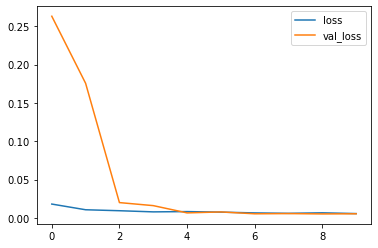

In [63]:
for key in ['loss', 'val_loss']:
    plt.plot(hist1.history[key],label=key)
plt.legend()
plt.savefig(os.path.join(project_folder,'loss.png'))
plt.show()

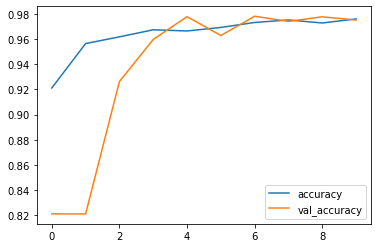

In [64]:
for key in ['accuracy', 'val_accuracy']:
    plt.plot(hist1.history[key],label=key)
plt.legend()
plt.savefig(os.path.join(project_folder,'accuracy.png'))
plt.show()

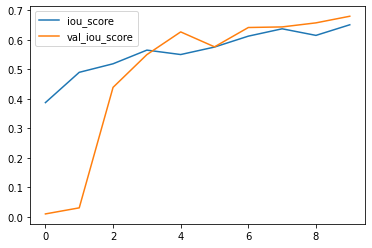

In [65]:
for key in ['iou_score', 'val_iou_score']:
    plt.plot(hist1.history[key],label=key)
plt.legend()
plt.savefig(os.path.join(project_folder,'IoU.png'))
plt.show()

In [66]:
# save model
model_path = os.path.join(project_folder, project_name+".h5")
model_1.save(model_path)

the number is 188


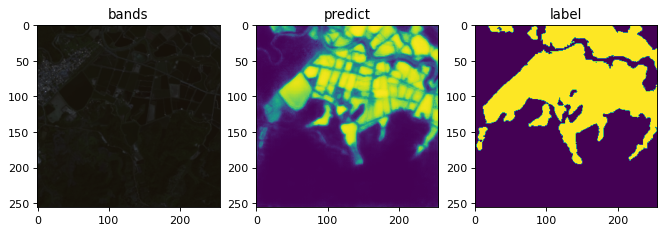

In [90]:
idx_num = random.randrange(len(x_val))
plt.figure(figsize=(10, 8), dpi=80)
print("the number is {0}".format(idx_num))
plt.subplot(131)
plt.title('bands')
plt.imshow(x_val[idx_num,:,:,0:3])
plt.subplot(132)
plt.title('predict')
plt.imshow(model_1.predict((np.expand_dims(x_val[idx_num,:,:,:],axis=0))).reshape((256,256,1)))
# plt.imshow(np.argmax(model_1.predict((np.expand_dims(x_val[idx_num,:,:,:],axis=0))),axis=-1).reshape((256,256,1)))
plt.subplot(133)
plt.title('label')
plt.imshow((y_val[idx_num,:,:]>0.5).reshape(256,256,1))

## predict

In [68]:
# when you have customized initializer, set custom objects before load the model (https://github.com/keras-team/keras/issues/3867)
from keras.utils import CustomObjectScope, get_custom_objects
class CustomInitializer:
    def __call__(self, shape, dtype=None):
        return my_init(shape, dtype=dtype)

get_custom_objects().update({'my_init': CustomInitializer})
get_custom_objects().update({"binary_focal_loss": segmentation_models.losses.BinaryFocalLoss()})
get_custom_objects().update({"iou_score": segmentation_models.metrics.IOUScore()})

In [69]:
model_final = load_model(model_path)

In [79]:
scene_dict = {'116060':'/workspace/_libs/116060_preprocessed'}

In [71]:
predict_ID = '116060'
sourcefolder = scene_dict[predict_ID]
folderlist = []
## get bands 2~7
for i in os.listdir(sourcefolder):
    if(i.endswith('rst')):
        folderlist.append(os.path.join(sourcefolder,i))
folderlist.sort()
folderlist
predict_data_source = []
for i in folderlist:
    ds = ReadData_geoinf(i)
    predict_data_source.append(ds['data'])
predict_data_source = np.stack(predict_data_source,axis=-1)

In [72]:
predict_chips = cut_array(predict_data_source, 256, 256, 128, 128)

In [73]:
predict_label = model_final.predict(predict_chips)

In [74]:
mosaic_weights = weights_generator('half_buffer', ds['Ysize'], ds['Xsize'], 256, 256, 128, 128)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]]


In [75]:
mosaic_res =  mosaic_chips(predict_label[:,:,:,0], range(len(predict_label)),mosaic_weights, ds['Ysize'], ds['Xsize'], 256, 256, 128, 128)

In [76]:
prediction_path = os.path.join(project_folder, project_name+'_prob_'+predict_ID+'.rst')
output_same(mosaic_res, os.path.join(sourcefolder,folderlist[0]), prediction_path, gdal.GDT_Float32)